In [395]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/03_adaptiveCA')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


from PIL import Image
from skimage.color import rgba2rgb
import cv2
from IPython.display import display, clear_output
from math import *
import time

from os import makedirs, path
from copy import deepcopy


from models.leniaCA import leniaCA
from src.utils import *
import pygame
plt.style.use('default') # if it's using the wrong style for some reason

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test

In [396]:
CHANNELS=3
RADIUS=20
ca = leniaCA(CHANNELS=CHANNELS, RADIUS=RADIUS).cuda() 

Text(0, 0.5, '$G(x)$')

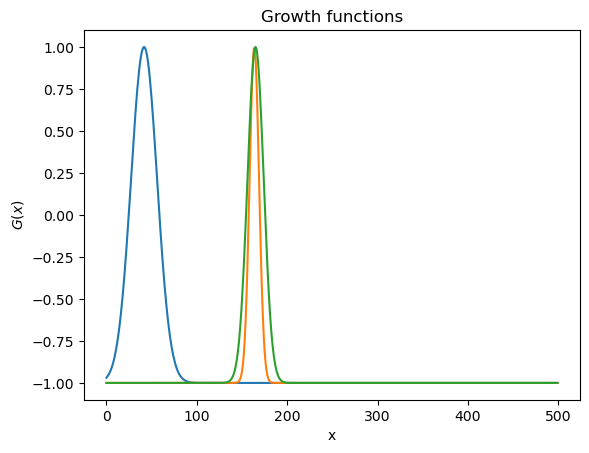

In [397]:
G_functions = ca.rule.G(torch.linspace(0, 1, 500).cuda()).cpu().numpy().squeeze()
plt.plot(G_functions.T)
plt.title('Growth functions')
plt.xlabel('x')
plt.ylabel(r'$G(x)$')

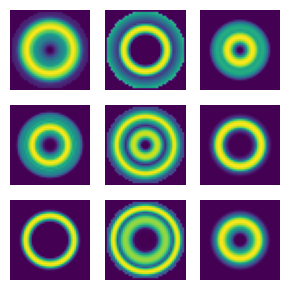

In [398]:
fig, axes = plt.subplots(CHANNELS, CHANNELS, figsize=(CHANNELS, CHANNELS))

if CHANNELS > 1:
    for i_ax in range(CHANNELS):
        for j_ax in range(CHANNELS):
            axes[i_ax, j_ax].imshow(ca.rule.K[i_ax, j_ax].detach().cpu().numpy())
            axes[i_ax, j_ax].axis('off')
else:
    axes.imshow(ca.rule.K[0, 0].detach().cpu().numpy())
    axes.axis('off')
        
plt.tight_layout()

In [399]:
# resolution of grid
RESX=256
RESY=256

# pygame stuff
######################################
pygame.init()
size = RESX, RESY
# screen = pygame.display.set_mode(size)
screen = pygame.Surface(size)
UPSCALE = 2
RESXup, RESYup = int(RESX*UPSCALE), int(RESY*UPSCALE)
upscaled_screen = pygame.display.set_mode([RESXup, RESYup])

running = True
time_ticking = True
LMB_trigger = False
RMB_trigger = False
brush_toggle = False
WHEEL_trigger = False
PARAM_INDEX = 0

# brush properties
r = 20
s = 1

clock = pygame.time.Clock()
font = pygame.font.SysFont("Noto Sans", 12)
######################################

state = ca.initGrid((RESX, RESY))

update_rate = 0.1
ticker = 0.
sink = False
export_imgs = False
imgs = []

with torch.no_grad():
    while running:              
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
            ''' 
            Keyboard shortcuts:
            - left/right to toggle through parameters
            - t to toggle totalistic rule
            - g to toggle growth kernel
            - s to toggle sink
            - e to toggle export_imgs
            - p to pause
            - r to reset
            - scroll wheel to permute through channel dims
            - LMB/RMB to make/delete
            '''
            
            # add/erase 
            if event.type == pygame.MOUSEBUTTONDOWN:
                if event.button == 1:
                    LMB_trigger = True
                if event.button == 3:
                    RMB_trigger = True
            if event.type == pygame.MOUSEBUTTONUP:
                if event.button == 1:
                    LMB_trigger = False
                if event.button == 3:
                    RMB_trigger = False
            
            if event.type== pygame.KEYDOWN and event.key == pygame.K_LEFT:
                PARAM_INDEX = (PARAM_INDEX - 1) % 2
            if event.type== pygame.KEYDOWN and event.key == pygame.K_RIGHT:
                PARAM_INDEX = (PARAM_INDEX + 1) % 2
            if event.type == pygame.MOUSEWHEEL:
                WHEEL_trigger = True
                direction = event.y     
                
            if event.type == pygame.KEYDOWN and event.key == pygame.K_SPACE:
                # generate random kernel params
                ca.rule.make_growth_function()
                ca.rule.make_kernel_function()
                
                # ca.rule.sigma = np.abs(np.random.randn() / 10)
                # ca.rule.mu = np.abs(np.random.randn())
                # ca.rule.alpha = np.abs(np.random.normal(4))
                # ca.rule.K = nn.Parameter(ca.rule.generate_kernel())
#                 ca.rule.K = nn.Parameter(ca.rule.generate_random_kernel())
#                 ca.rule.K = nn.Parameter(ca.rule.generate_cppn_kernel())
#                 ca.rule.K = nn.Parameter(ca.rule.generate_cppn_kernels())

            if event.type== pygame.KEYDOWN and event.key == pygame.K_s:
                # toggle sink
                sink = not sink
            if event.type== pygame.KEYDOWN and event.key == pygame.K_e:
                # export video
                export_imgs = not export_imgs
            if event.type== pygame.KEYDOWN and event.key == pygame.K_p:
                # pause/toggle time
                time_ticking = not time_ticking                
            if event.type== pygame.KEYDOWN and event.key == pygame.K_r:
                # start from seed 
                state = ca.initGrid((RESX, RESY))
                

        mouse_pos = pygame.mouse.get_pos()
        if LMB_trigger:
            state = click(state, rmb=False, r=r, s=s, upscale=UPSCALE, brush_toggle=brush_toggle)
        if RMB_trigger:
            state = click(state, rmb=True, r=r, s=s, upscale=UPSCALE, brush_toggle=brush_toggle)
            
        if WHEEL_trigger:
            update_rate = WHEEL_param(update_rate, direction, 1./3.)
            WHEEL_trigger = False
        
            
#         nx = state.cpu()[:, cdim_order].numpy()[0, 0, :, :].transpose(1, 2, 0)
        if CHANNELS == 1:
            nx = state.cpu().numpy()[0, 0, :, :]
        else:
            nx = state.cpu().numpy()[0, 0:3, :, :].transpose(1, 2, 0)
        nx = nx * 255

        if time_ticking:
            state = ca.forward(state, update_rate)
            ticker += 1
    
            if sink:
                xv, yv = torch.linspace(-1, 1, RESX), torch.linspace(-RESY/RESX, RESY/RESX, RESY)
                X, Y = torch.meshgrid(xv, yv)
                amp = 0.00
                w = 30
                R = torch.sqrt(X**2 + Y**2).cuda()
                state = torch.clip(torch.where(R > 0.5, state - 0.05*R*torch.ones_like(state).cuda(), state), 0, 1)

            if export_imgs:
                imgs.append(nx)
        
    
        # blit_mat()
        pygame.surfarray.blit_array(screen, nx)        
        
        
        # upscale and display
        frame = pygame.transform.scale(screen, (RESXup, RESYup))
        upscaled_screen.blit(frame, frame.get_rect())
        upscaled_screen.blit(update_fps(clock, font), (10,0))
        # ca params
        upscaled_screen.blit(show_param_info(update_rate, 'update_rate'), (RESXup - 100,0))
        if CHANNELS == 1:
            upscaled_screen.blit(show_param_info(ca.rule.mu, 'mu'), (10,20))
            upscaled_screen.blit(show_param_info(ca.rule.sigma, 'sigma'), (10,30))
        pygame.display.flip()
        clock.tick(240)
        
pygame.quit()


(array([62237.,    87.,    89.,    79.,    84.,    66.,    82.,    71.,
           99.,  2642.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

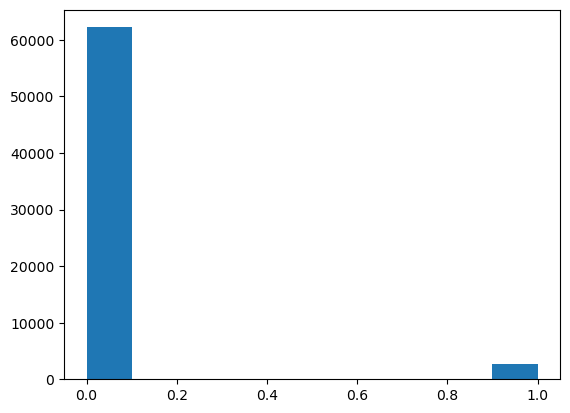

In [400]:
plt.hist(state[0, 1].cpu().numpy().reshape(-1))

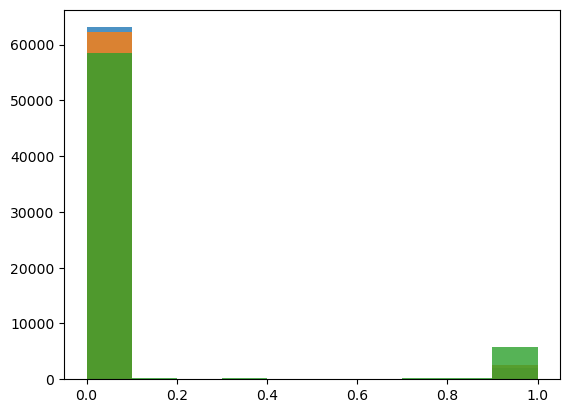

In [401]:
[plt.hist(state[0, i].cpu().numpy().reshape(-1), alpha=0.8) for i in range(CHANNELS)];

In [402]:
fname = time.strftime("%Y%m%d-%H%M%S")
# out = cv2.VideoWriter(f'videos/CA-{fname}.avi',cv2.VideoWriter_fourcc(*'DIVX'), 60, (RESX, RESY), 3)
out = cv2.VideoWriter(f'videos/CA-{fname}.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 60, (RESX, RESY), 1)


for img in imgs:
#     img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)*255.0)
    img = np.uint8(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)).transpose(1, 0, 2)
    out.write(img)
out.release()

(array([183922.,    315.,    271.,    282.,    235.,    253.,    271.,
           256.,    367.,  10436.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

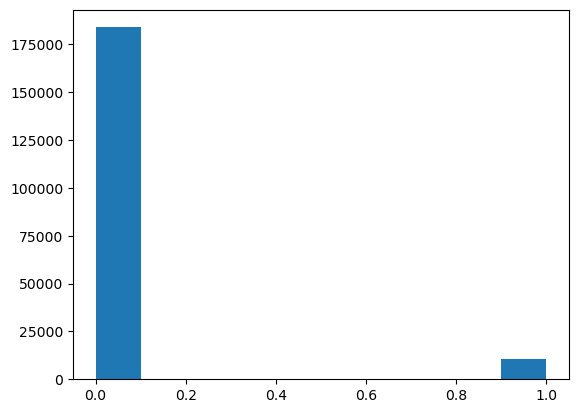

In [403]:
plt.hist(state.reshape(-1).cpu().detach().numpy())

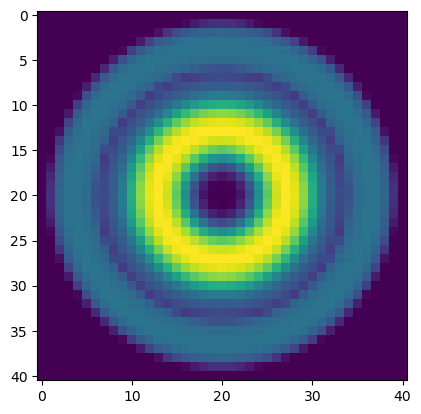

In [404]:
plt.imshow(ca.rule.K.detach().cpu().numpy()[0, 0])

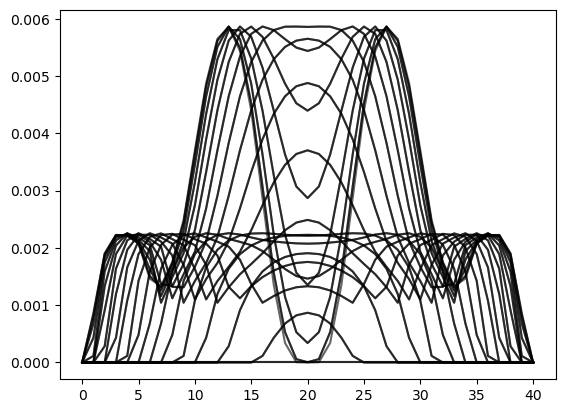

In [405]:
plt.plot(ca.rule.K.detach().cpu().numpy()[0, 0], c='k', alpha=0.6);